In [1]:
from GNNTrain import train, predict_from_saved_model
from GraphSageModel import GNN7L_Sage
from CreateGraph import create_graph_from_PPI
from CreateDataset import get_dataset_from_graph

import pandas as pd
import seaborn as sn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.conv import SAGEConv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
disease_Id = 'C0036341'

In [3]:
graph_path = create_graph_from_PPI('Datasets/BIOGRID-ORGANISM-Homo_sapiens-4.4.206.tab3.txt', disease_Id, 'grafo_nedbit_' + disease_Id)
graph_path

[+] Reading PPI...ok
[+] Creating the graph...ok
	[+] Added 19764 nodes
	[+] Added 682198 edges
[+] Removing self loops...ok
	[+] 19764 nodes
	[+] 678932 edges
[+] Taking the LCC...ok
	[+] 19761 nodes
	[+] 678932 edges
[+] Adding NeDBIT features...ok
[+] Saving graph to path: Graphs/grafo_nedbit_C0036341.gml
[i] Elapsed time: 44.156


'Graphs/grafo_nedbit_C0036341.gml'

In [4]:
dataset = get_dataset_from_graph(graph_path, disease_Id)
dataset

[+] Reading graph...ok
[+] Creating dataset...ok
[i] Elapsed time: 33.837


Data(edge_index=[2, 1357864], x=[19761, 6], y=[19761], num_classes=5, train_mask=[19761], test_mask=[19761], val_mask=[19761])

### Results without training

              precision    recall  f1-score   support

           0       0.56      0.97      0.71       124
           1       0.89      0.72      0.80       710
           2       0.52      0.86      0.65       710
           3       0.82      0.07      0.13       710
           4       0.75      0.99      0.86       710

    accuracy                           0.68      2964
   macro avg       0.71      0.72      0.63      2964
weighted avg       0.74      0.68      0.61      2964



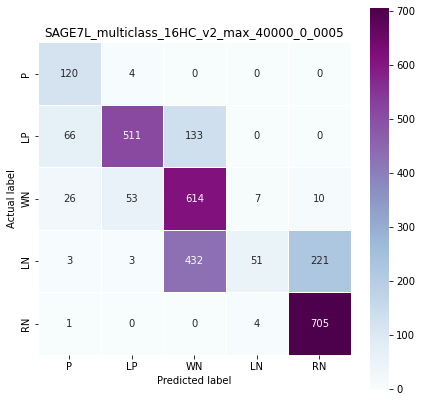

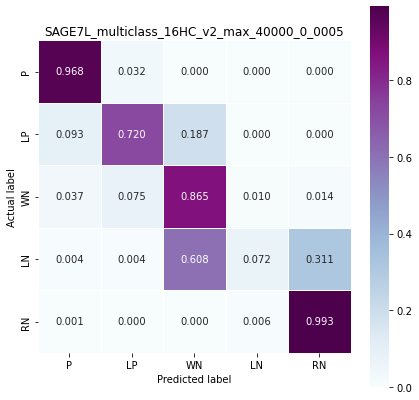

In [5]:
predict_from_saved_model('SAGE7L_multiclass_16HC_v2_max_40000_0_0005', dataset.to(device), ['P', 'LP', 'WN', 'LN', 'RN'], files_name='GraphSAGE_' + disease_Id + '_nonTrained')

### Results with training

  0%|          | 0/40001 [00:00<?, ?it/s]

[Epoch: 0000] train loss: 51.6491, train acc: 0.1092, val loss: 17.1695, val acc: 0.0425  (best train acc: 0.1092, best val acc: 0.0425, best train loss: 51.6491  @ epoch 0 )
[Epoch: 0020] train loss: 2.3694, train acc: 0.1708, val loss: 1.8692, val acc: 0.0975  (best train acc: 0.2640, best val acc: 0.2944, best train loss: 2.3694  @ epoch 20 )
[Epoch: 0040] train loss: 1.5887, train acc: 0.2984, val loss: 1.4797, val acc: 0.3427  (best train acc: 0.3044, best val acc: 0.3427, best train loss: 1.5887  @ epoch 40 )
[Epoch: 0060] train loss: 1.4484, train acc: 0.3560, val loss: 1.3877, val acc: 0.4118  (best train acc: 0.3560, best val acc: 0.4142, best train loss: 1.4475  @ epoch 58 )
[Epoch: 0080] train loss: 1.3862, train acc: 0.3944, val loss: 1.3446, val acc: 0.4304  (best train acc: 0.3944, best val acc: 0.4304, best train loss: 1.3862  @ epoch 80 )
[Epoch: 0100] train loss: 1.3894, train acc: 0.3679, val loss: 1.3182, val acc: 0.4546  (best train acc: 0.4069, best val acc: 0.4546

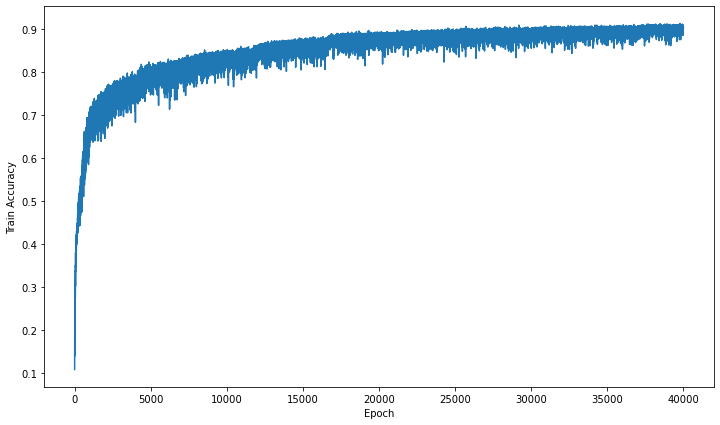

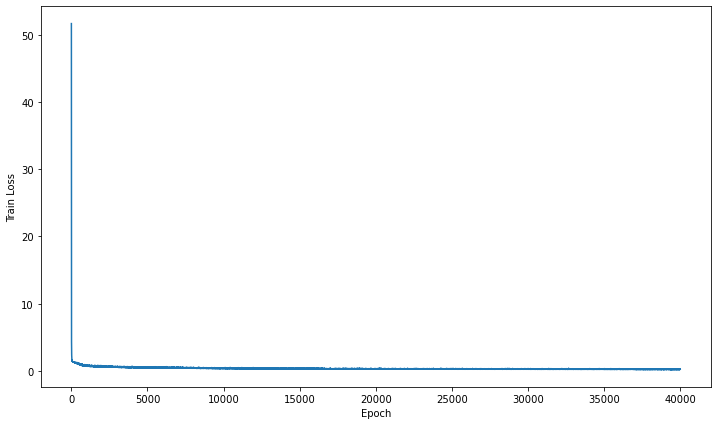

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       124
           1       0.94      0.96      0.95       710
           2       0.94      0.88      0.91       710
           3       0.84      0.84      0.84       710
           4       0.86      0.90      0.88       710

    accuracy                           0.90      2964
   macro avg       0.91      0.91      0.91      2964
weighted avg       0.90      0.90      0.90      2964



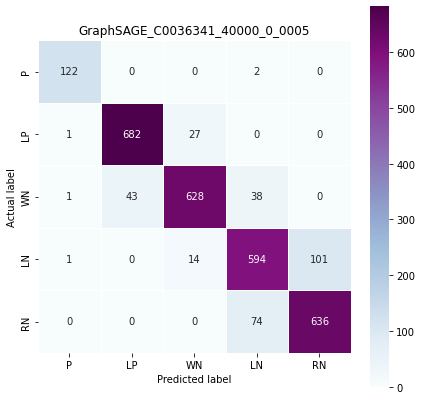

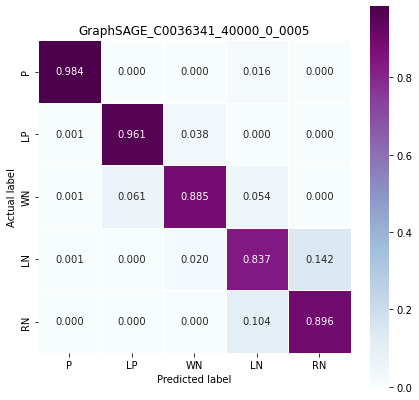

In [6]:
lr              = 0.001
epochs          = 40000
weight_decay    = 0.0005

classes         = ['P', 'LP', 'WN', 'LN', 'RN']
gnn_model = GNN7L_Sage(dataset).to(device)
pred = train(gnn_model, dataset, epochs, lr, weight_decay, classes, 'GraphSAGE_' + disease_Id)